In [1]:
import ctypes
import sys
import os 
import numpy as np
from ctypes import POINTER
import matplotlib.pyplot as plt
from mc_for_bimetric import log_likelihood,log_post
import emcee

In [2]:
cwd =  os.getcwd()
lib_h = ctypes.CDLL(cwd + "/friedmann_Cs_lib.so") 

In [3]:
def load_data(fname="data.txt"):
    f = np.genfromtxt(fname,delimiter="\t")
    z = np.squeeze(f[:,0])
    fs8_data = np.squeeze(f[:,1])
    fs8_sig2 = np.square(np.squeeze(f[:,2]))
    om_fid = np.squeeze(f[:,3])
    
    c = np.diag(fs8_sig2)
    c[5,5] = 6.4000*0.001
    c[4,4] = 3.969*0.001
    c[3,3] = 5.184*0.001
    c[4,5] = 2.570*0.001
    c[3,5] = 0.000
    c[5,4] = 2.570*0.001
    c[3,4] = 2.540*0.001
    c[5,3] = 0.000*0.001
    c[4,3] = 2.540*0.001
    
    c_i = np.linalg.inv(c)
    rat_den = np.sqrt(om_fid*np.power(1.0+z,3.0)+(1.0-om_fid))
    mz = -1.0*z
    sa = mz.argsort()
    sa_inv = mz.argsort().argsort()
    
    cn = np.array([1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,3,3,3])
    
    return z,fs8_data,c_i,rat_den,sa,sa_inv,cn
    
    

In [4]:
z,f,ci,r,s,si,cn = load_data()

In [5]:
cn[s]

array([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3])

In [6]:
l = log_post([0.4,0.0,0.79],z,f,r,ci,cn,s,si)

In [11]:
nwalkers = 10
ndim = 3
ini_guess =  np.array([0.3,0.0,0.79])+1e-4 * np.random.randn(nwalkers, ndim)
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, backend=backend,args=(z,f,r,ci,cn,s,si))

In [12]:
sampler.run_mcmc(ini_guess, 100, progress=True);

  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/manvendra/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


In [9]:
samples =sampler.get_chain()

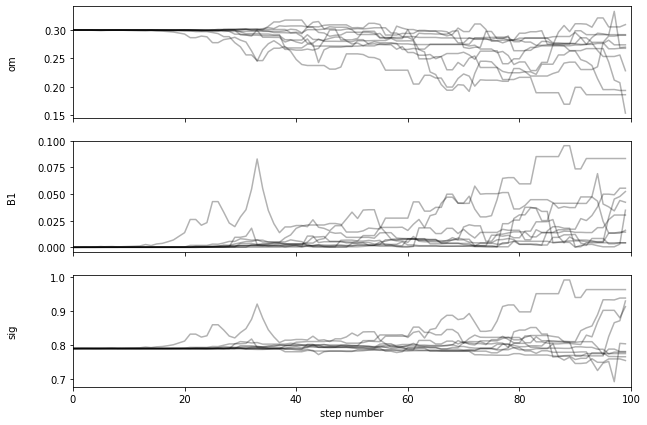

In [10]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["om", "B1", "sig"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");